In [6]:
from mqdq import utils, babble, elegy
from mqdq import line_analyzer as la
from mqdq import mahalanobis as maha

import bs4

import numpy as np
import pandas as pd
import scipy as sp

import glob

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, cross_validate
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
from xgboost import XGBClassifier

In [7]:
collection = []

# Several lines need to be manually deleted, because when we make wide vectors
# we treat couplets as a unit (so we must have a matching number of H and P.)
# In some poems, we have corrupt lines, and so we delete the H that matches
# a corrupt P and vice versa.

ep = babble.bookbabs('ovid/OV-epis.xml', name="Ep.")
for b in ep:
    b.author = 'Ovid'
collection.extend(ep)

tr = babble.multi_bookbabs(sorted(glob.glob('ovid/OV-tri*.xml')), name="Tr.")
for b in tr:
    b.author = 'Ovid'
collection.extend(tr)

am = babble.multi_bookbabs(sorted(glob.glob('ovid/OV-amo*.xml')), name="Am.")
for b in am:
    b.author = 'Ovid'
collection.extend(am)

tib = babble.multi_bookbabs(sorted(glob.glob('TIB-ele*.xml')), name="Tib.")
del tib[1].raw_source[24]
for b in tib:
    b.author = 'Tibullus'
collection.extend(tib)

prop = babble.multi_bookbabs(sorted(glob.glob('PROP-ele*.xml')), name="Prop.")
for b in prop:
    b.author = 'Propertius'
del prop[55].raw_source[28]
collection.extend(prop)

cat = babble.bookbabs('CATVLL-carm.xml', name="Cat.")
cat_ele = [x for x in cat if x.elegiac and len(x) > 20]
for b in cat_ele:
    b.author = 'Catullus'
del cat_ele[3].raw_source[46]
collection.extend(cat_ele)

pon = babble.multi_bookbabs(sorted(glob.glob('ovid/OV-pon*.xml')), name="Pont.")
for b in pon:
    b.author = 'Ovid'
del pon[1].raw_source[8]
del pon[7].raw_source[18]
collection.extend(pon)


In [8]:
vecs = elegy.vectorise_babs(collection)
vecs

,Author,Work,Poem,H1SP,H2SP,H3SP,H4SP,H1CF,H2CF,H3CF,...,P4SC,P1WC,P2WC,P3WC,P4WC,ELC,RS,LEO,LEN,PFSD
0,Ovid,Ep.,Ep. 1,0.086207,0.500000,0.500000,0.448276,0.241379,0.706897,0.810345,...,0.0,0.206897,0.068966,0.396552,1.000000,0.094828,4.393948,0.739842,116,0.000000
1,Ovid,Ep.,Ep. 2,0.189189,0.527027,0.581081,0.391892,0.283784,0.743243,0.878378,...,0.0,0.202703,0.067568,0.337838,1.000000,0.114865,4.071062,1.027448,148,0.000000
2,Ovid,Ep.,Ep. 3,0.220779,0.493506,0.519481,0.480519,0.181818,0.597403,0.818182,...,0.0,0.116883,0.025974,0.324675,1.000000,0.090909,3.845700,0.484285,154,0.000000
3,Ovid,Ep.,Ep. 4,0.102273,0.511364,0.545455,0.465909,0.147727,0.659091,0.829545,...,0.0,0.215909,0.045455,0.329545,1.000000,0.073864,3.822098,0.893575,176,0.000000
4,Ovid,Ep.,Ep. 5,0.215190,0.455696,0.632911,0.417722,0.164557,0.658228,0.911392,...,0.0,0.202532,0.037975,0.341772,1.000000,0.056962,3.727347,0.713715,158,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,Ovid,Pont.,Pont. 4 12,0.120000,0.520000,0.720000,0.440000,0.240000,0.560000,0.920000,...,0.0,0.280000,0.040000,0.280000,1.000000,0.100000,3.073075,0.615696,50,0.000000
274,Ovid,Pont.,Pont. 4 13,0.160000,0.600000,0.680000,0.800000,0.280000,0.720000,0.920000,...,0.0,0.240000,0.080000,0.360000,0.880000,0.100000,5.954342,1.723439,50,0.775629
275,Ovid,Pont.,Pont. 4 14,0.129032,0.580645,0.548387,0.645161,0.096774,0.774194,0.903226,...,0.0,0.193548,0.032258,0.193548,0.903226,0.064516,3.314164,1.155196,62,0.591300
276,Ovid,Pont.,Pont. 4 15,0.095238,0.619048,0.666667,0.619048,0.285714,0.666667,0.714286,...,0.0,0.285714,0.095238,0.333333,0.952381,0.119048,3.695211,0.919168,42,0.425918


In [5]:
vecs.LEN.sum()

3952

In [187]:
print(pd.pivot_table(vecs, index=['Author','Work'], values=['LEN'],aggfunc=['count','min','max']).reset_index().to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
     Author &   Work & count &  min &  max \\
            &   LEN &  LEN &  LEN \\
\midrule
   Catullus &   Cat. &     5 &   24 &  158 \\
       Ovid &    Am. &    49 &   18 &  114 \\
       Ovid &    Ep. &    21 &  116 &  376 \\
       Ovid &  Pont. &    46 &   22 &  166 \\
       Ovid &    Tr. &    50 &   26 &  578 \\
 Propertius &  Prop. &    91 &    6 &  150 \\
   Tibullus &   Tib. &    16 &   22 &  122 \\
\bottomrule
\end{tabular}



In [169]:
vecs.groupby('Work').agg({'LEN':'min'})

,LEN
Work,
Am.,18
Cat.,24
Ep.,116
Pont.,22
Prop.,6
Tib.,22
Tr.,26


In [25]:
pa = lambda: make_pipeline(
    StandardScaler(),
    PassiveAggressiveClassifier(max_iter=1000, tol=1e-3, C=1.0, loss='squared_hinge')
)
etn = lambda: make_pipeline(
    StandardScaler(),
    ExtraTreesClassifier(n_estimators=5000, max_features=15, criterion='gini', n_jobs=-1)
)
svmn = lambda: make_pipeline(
    StandardScaler(),
    SVC(gamma='scale', kernel='rbf', C=128)
)
lin_svmn = lambda: make_pipeline(
    StandardScaler(),
    LinearSVC()
)
mnbnorm =  lambda: make_pipeline(
    # don't centre the data around 0, otherwise
    # the MultinomialNB classifier breaks
    StandardScaler(with_mean=False),
    MultinomialNB()
)
gnbnorm =  lambda: make_pipeline(
    # don't centre the data around 0, otherwise
    # the MultinomialNB classifier breaks since
    # multinomial expects count data (non-negative)
    StandardScaler(with_mean=False),
    GaussianNB()
)
nc =  lambda: make_pipeline(
    StandardScaler(),
    NearestCentroid()
)

xgb = lambda: make_pipeline(
    #StandardScaler(),
    XGBClassifier(objective="multi:softprob", random_state=42)
)

CLASSIFIERS = [
    ('PassiveAggressive', pa),
    #('ExtraTreesNorm', etn),
    ('XGBoost',xgb),
    #('Linear SVM', lin_svmn),
    ('SVM', svmn),
    #('MultinomialNB', mnbnorm),
    ('NearestCentroid', nc)
]

In [12]:
def test_clfs(clfs, corp, feats, by, cutoff=0, seed=None, samps=20):
    """
    Test the given classifiers on a corpus.
    
    Multi-label fitting strategy is up to each classifier.
    """
    res = []
    # this makes a seeded rng, instead of seeding the ShuffleSplit
    # with the same value each time, which seems slightly cleaner.
    rng = np.random.RandomState(seed=seed)
    for (name, c) in clfs:
        trimmed = corp[corp.LEN >= cutoff]
        X,y = trimmed[feats], trimmed[by]
        cv = StratifiedShuffleSplit(n_splits=samps, test_size=0.2, random_state=rng)
        # note to self: don't run parallel jobs if you have a seeded rng >:(
        jobs = -1
        if seed:
            jobs = 1
        samp_res = cross_val_score(c(), X, y, cv=cv, n_jobs=jobs, scoring='f1_weighted')
        m = sp.mean(samp_res)
        ci = sp.stats.t.interval(
            alpha=0.95,
            df=len(samp_res)-1,
            loc=m,
            scale=sp.stats.sem(samp_res)
        ) 
        res.append({'Classifier':name, 'Score':m, 'Cutoff': cutoff, 'CILow':ci[0], 'CIHigh':ci[1]})
    return pd.DataFrame(res)

In [14]:
cols = list(vecs.columns[3:])

In [23]:
test_clfs(CLASSIFIERS, vecs, cols, 'Work', cutoff=0, samps=100)

,Classifier,Score,Cutoff,CILow,CIHigh
0,PassiveAggressiveNorm,0.655801,0,0.645139,0.666463
1,XGBoost,0.666136,0,0.655985,0.676288
2,Linear SVM,0.668699,0,0.658254,0.679144
3,SVM,0.692409,0,0.681337,0.703481
4,NearestCentroid,0.701404,0,0.691552,0.711255


In [24]:
test_clfs(CLASSIFIERS, vecs, cols, 'Author', cutoff=0, samps=100)

,Classifier,Score,Cutoff,CILow,CIHigh
0,PassiveAggressiveNorm,0.917159,0,0.910869,0.923448
1,XGBoost,0.918775,0,0.912508,0.925043
2,Linear SVM,0.912449,0,0.906856,0.918042
3,SVM,0.932964,0,0.927465,0.938463
4,NearestCentroid,0.937522,0,0.932070,0.942974


In [124]:
test_clfs(CLASSIFIERS, vecs[(vecs.Work != 'Tr.') & (vecs.Work != 'Pont.')], cols, 'Author', cutoff=0, samps=100)

,Classifier,Score,Cutoff,CILow,CIHigh
0,ExtraTreesNorm,0.910986,0,0.905331,0.916642
1,SVMNorm,0.916770,0,0.908168,0.925372
2,MultinomialNB,0.884273,0,0.873673,0.894874
3,NearestCentroid,0.917865,0,0.910595,0.925135


In [26]:
dfs = []
for n in range(0,80,5):
    dfs.append(test_clfs(CLASSIFIERS, vecs, cols, 'Work', cutoff=n, samps=100))
bywork = pd.concat(dfs)
bywork

,Classifier,Score,Cutoff,CILow,CIHigh
0,PassiveAggressive,0.675026,0,0.664009,0.686043
1,XGBoost,0.659588,0,0.650539,0.668638
2,SVM,0.693418,0,0.682954,0.703882
3,NearestCentroid,0.705904,0,0.696860,0.714948
0,PassiveAggressive,0.664772,5,0.655005,0.674539
...,...,...,...,...,...
3,NearestCentroid,0.592590,70,0.573873,0.611306
0,PassiveAggressive,0.568141,75,0.546822,0.589459
1,XGBoost,0.635557,75,0.612791,0.658322
2,SVM,0.621528,75,0.603354,0.639703


In [28]:
%load_ext rpy2.ipython

/Users/ben/silius/silius_env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [29]:
dicts = []
for n in range(0,80,10):
    dicts.append({'Cutoff':n, 'N':len(vecs[vecs.LEN >= n])})
n_df = pd.DataFrame(dicts)
n_df

,Cutoff,N
0,0,278
1,10,277
2,20,270
3,30,236
4,40,194
5,50,156
6,60,113
7,70,90


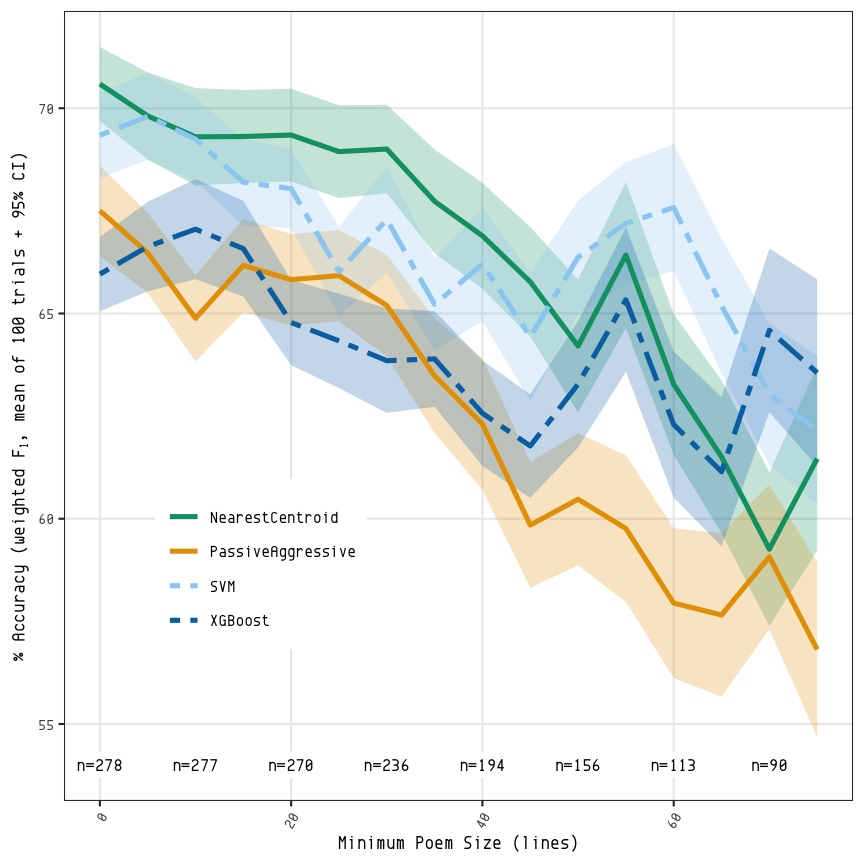

In [44]:
%%R -i bywork,n_df -h 6 -w 6 -u in -r 144
library(ggplot2)
library(extrafont)
cbbPaletteDark <- c("#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")
greys <- c(grey(0),grey(0.35), grey(0.45), grey(0.75))

ggplot(data=bywork, aes(x=Cutoff, y=Score*100)) +
#This CI band is not shown in the B&W figure, because it's not useful in monochrome
geom_label(
    data=n_df,
    label.size=NA,
    aes(x=Cutoff, y=54, label=sprintf("n=%d",N)),
    family="Envy Code R",
    size=3
) +
geom_ribbon(
    aes(ymin=CILow*100, ymax=CIHigh*100, fill=Classifier), 
    alpha=0.25, show.legend=FALSE) +
geom_line(aes(color=Classifier,linetype=Classifier), size=1.2) +

labs(x="Minimum Poem Size (lines)",y=expression(paste("% Accuracy (weighted ",F[1],", mean of 100 trials + 95% CI)"))) +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.title=element_blank()) +
guides(color = guide_legend(ncol=2)) +
theme(legend.title=element_blank(), legend.position= c(0.25, 0.3), legend.text=element_text(size=8)) +
theme(axis.text.x = element_text(angle = 60, hjust = 1, vjust=1)) +
scale_linetype_manual(values=c("solid", "solid", "twodash", "twodash")) +
scale_color_manual(values=cbbPaletteDark) +
scale_fill_manual(values=cbbPaletteDark)

# fn <- "/Users/ben/silius/ep15/poetics_acc_work.pdf"
# ggsave(fn, dpi=600, width=6, height=6)
# embed_fonts(fn)
# system(sprintf("pdfcrop %s", fn))

In [34]:
dfs = []
for n in range(0,80,5):
    dfs.append(test_clfs(CLASSIFIERS, vecs, cols, 'Author', cutoff=n, samps=100))
byauth = pd.concat(dfs)
byauth

,Classifier,Score,Cutoff,CILow,CIHigh
0,PassiveAggressive,0.915827,0,0.909134,0.922519
1,XGBoost,0.924208,0,0.917740,0.930676
2,SVM,0.931461,0,0.925228,0.937693
3,NearestCentroid,0.937580,0,0.931744,0.943415
0,PassiveAggressive,0.914721,5,0.908362,0.921081
...,...,...,...,...,...
3,NearestCentroid,0.939907,70,0.930175,0.949639
0,PassiveAggressive,0.938854,75,0.927622,0.950085
1,XGBoost,0.849894,75,0.835127,0.864661
2,SVM,0.921909,75,0.908821,0.934997


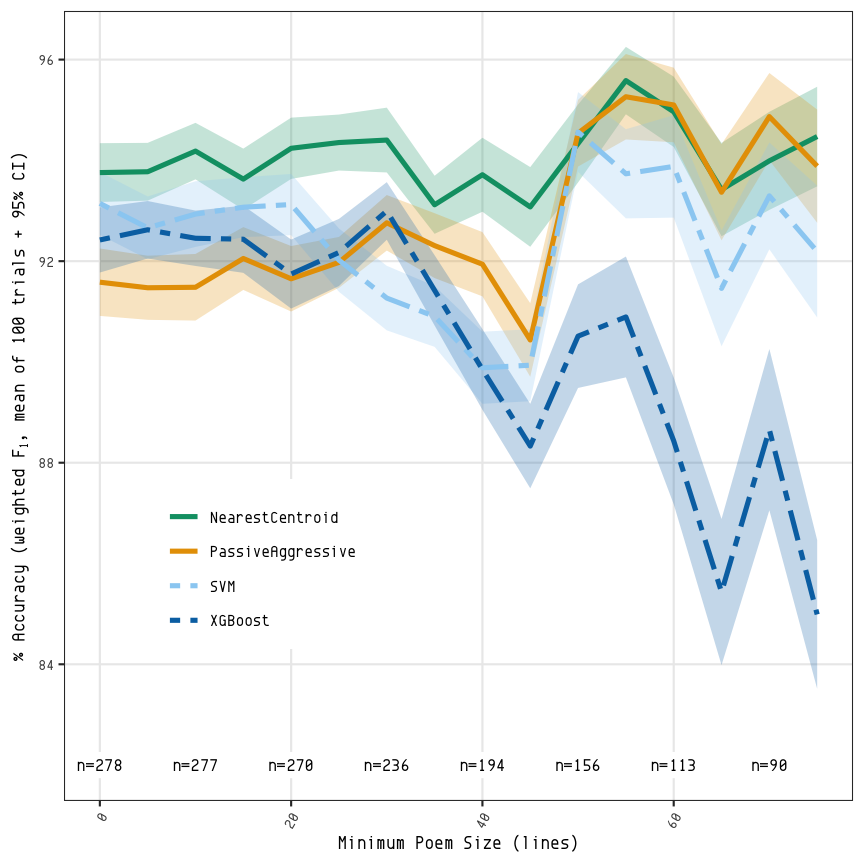

In [46]:
%%R -i byauth,n_df -h 6 -w 6 -u in -r 144
library(ggplot2)
cbbPaletteDark <- c("#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")
greys <- c(grey(0),grey(0.35), grey(0.45), grey(0.75))

ggplot(data=byauth, aes(x=Cutoff, y=Score*100)) +
#This CI band is not shown in the B&W figure, because it's not useful in monochrome
geom_label(
    data=n_df,
    label.size=NA,
    aes(x=Cutoff, y=82, label=sprintf("n=%d",N)),
    family="Envy Code R",
    size=3
) +
geom_ribbon(
    aes(ymin=CILow*100, ymax=CIHigh*100, fill=Classifier), 
    alpha=0.25, show.legend=FALSE) +
geom_line(aes(color=Classifier,linetype=Classifier), size=1.2) +

labs(x="Minimum Poem Size (lines)",y=expression(paste("% Accuracy (weighted ",F[1],", mean of 100 trials + 95% CI)"))) +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.title=element_blank()) +
guides(color = guide_legend(ncol=2)) +
theme(legend.title=element_blank(), legend.position= c(0.25, 0.3), legend.text=element_text(size=8)) +
theme(axis.text.x = element_text(angle = 60, hjust = 1, vjust=1)) +
scale_linetype_manual(values=c("solid", "solid", "twodash", "twodash")) +
scale_color_manual(values=cbbPaletteDark) +
scale_fill_manual(values=cbbPaletteDark)

# fn <- "/Users/ben/silius/ep15/poetics_acc_auth.pdf"
# ggsave(fn, dpi=600, width=6, height=6)
# embed_fonts(fn)
# system(sprintf("pdfcrop %s", fn))

In [60]:
conf_matrix_list_of_arrays = []
X = vecs.drop(['Author','Work','Poem'], axis=1)
y = vecs.Work
names = sorted(y.unique())
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
clf = make_pipeline(
    StandardScaler(),
    NearestCentroid(),
)

for train_index, test_index in sss.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    conf_matrix = confusion_matrix(y_test, clf.predict(X_test))
    conf_matrix_list_of_arrays.append(conf_matrix)

In [61]:
conf_mat = np.mean(conf_matrix_list_of_arrays, axis=0)

In [62]:
# build the df for ggplot
cm_pct = [x/x.sum()*100 for x in conf_mat]
m = []
names = sorted(vecs['Work'].unique())
for y,arr in enumerate(cm_pct):
    for x,val in enumerate(arr):
        m.append({'x':names[x], 'y':names[y], 'val':val})
cmdf = pd.DataFrame(m)
cmdf.head()

,x,y,val
0,Am.,Am.,61.7
1,Cat.,Am.,0.0
2,Ep.,Am.,1.2
3,Pont.,Am.,11.3
4,Prop.,Am.,0.0


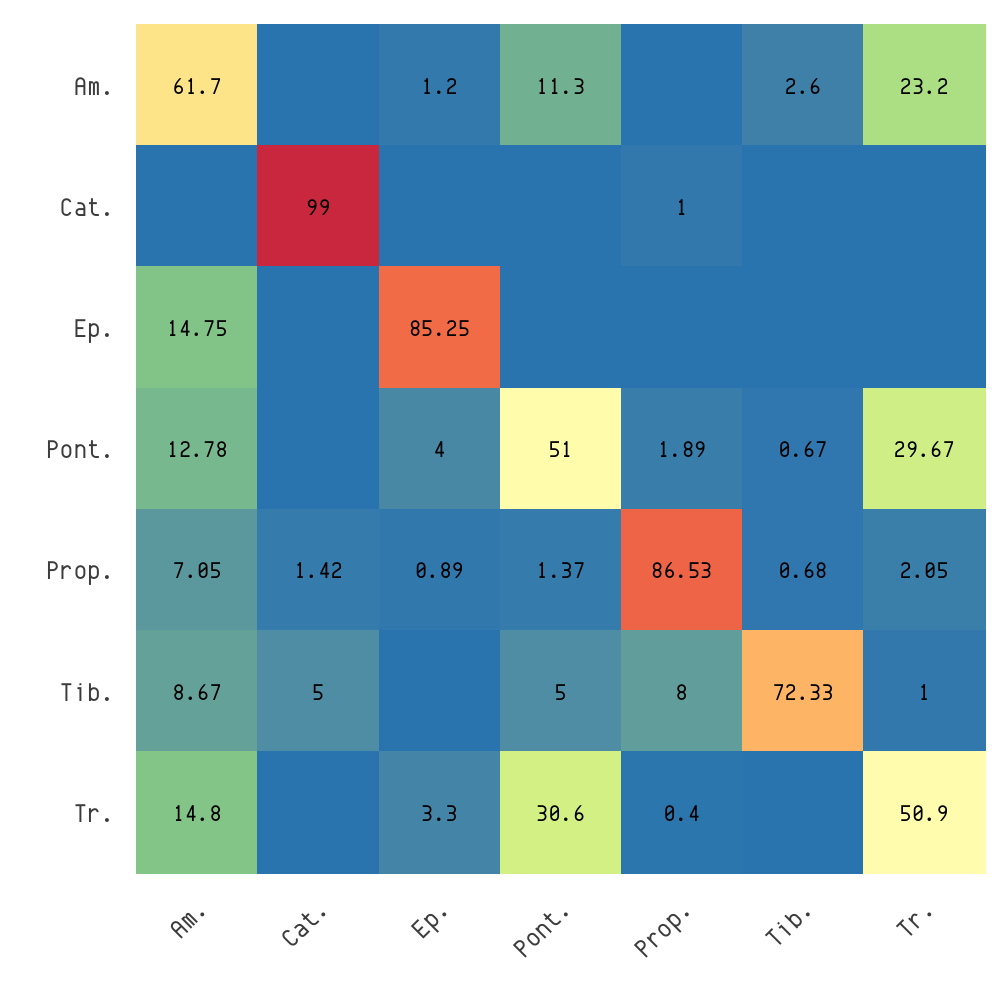

In [65]:
%%R -i cmdf -h 7 -w 7 -u in -r 144

source('/Users/ben/r/theme_black.R')

library(tidyverse)
library(extrafont)
cmdf <- cmdf %>%
  mutate(x = factor(x, levels= unique(x)), # alphabetical order by default
         y = factor(y, levels = rev(unique(y)))) # force reverse alphabetical order
    
ggplot(cmdf, aes(x=x, y=y, fill=val)) +
# slightly overlap the tiles to avoid a visible border line
geom_tile(width=1.01, height=1.01) +
scale_fill_distiller(palette="Spectral", direction=-1) +
guides(fill=F) + # removing legend for `fill`
theme_minimal() +
# force it to be square
coord_equal() +
# supress output for 0
geom_text(
    aes(label=ifelse(round(cmdf$val,digits=2)==0, "", round(val,digits=2))),
    color="black",
    size=4,
    family="Envy Code R") + 
theme(
    text = element_text(size=16, family="Envy Code R"),
    panel.grid.minor=element_blank(),
    panel.grid.major=element_blank(),
    panel.border=element_blank(),
    legend.title=element_blank()
) +
theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust=0.95)) +
labs(x="", y="") +
theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

# fn <- "ep15/cm_poetics.pdf"
# ggsave(fn, dpi=600, height=7, width=7)
# embed_fonts(fn)
# system(sprintf("pdfcrop %s", fn))